# Import Library

In [3]:
import numpy as np
import cv2
import os
import random
import shutil
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

%matplotlib inline


# Prerpocessing Data dengan Face Detection Haarcascade

In [ ]:

# Mendefinisikan path ke folder training_set
folder_path = '/content/drive/MyDrive/faceshape/validation_set'

# Daftar semua kelas bentuk wajah
face_shape = ['Square', 'Oblong', 'Round', 'Oval', 'Heart']

# Mendefinisikan path ke folder baru untuk menyimpan gambar wajah yang sudah di-crop
output_folder = '/content/drive/MyDrive/faceshape/validation_cropped'

# Membuat folder baru jika belum ada
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Mendapatkan path untuk setiap kelas dan mengimpor gambar-gambar dari setiap kelas
for kelas in face_shape:
    face_shape_folder = os.path.join(folder_path, kelas)
    file_names = os.listdir(face_shape_folder)
    
    for file_name in file_names:
        # Mendapatkan path file gambar
        image_path = os.path.join(face_shape_folder, file_name)

        # Membaca gambar
        img = cv2.imread(image_path)

        # Lakukan deteksi wajah dengan menggunakan Haar cascade
        haar = cv2.CascadeClassifier('/content/drive/MyDrive/cascade/haarcascade_frontalface_default.xml')
        faces = haar.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Melakukan operasi lainnya terhadap gambar, seperti cropping wajah
        for (x, y, w, h) in faces:
            # Menyesuaikan ROI
            x -= 15
            y -= 50
            w += 50
            h += 75

            # Memastikan koordinat berada dalam batas gambar
            x = max(0, x)
            y = max(0, y)
            w = min(img.shape[1] - x, w)
            h = min(img.shape[0] - y, h)

            # Melakukan cropping wajah
            cropped_img = img[y:y+h, x:x+w]

            # Simpan gambar wajah yang sudah di-crop ke dalam folder baru sesuai kelas wajah
            output_folder_path = os.path.join(output_folder, kelas)
            if not os.path.exists(output_folder_path):
                os.makedirs(output_folder_path)
            output_path = os.path.join(output_folder_path, file_name)
            cv2.imwrite(output_path, cropped_img)

print("Proses cropping dan penyimpanan gambar selesai.")

Proses cropping dan penyimpanan gambar selesai.


In [ ]:
# Path ke folder "faceshape"
faceshape_path = "/content/drive/MyDrive/faceshape"

# Path ke folder "training_cropped" dan "validation_cropped"
training_path = os.path.join(faceshape_path, "training_cropped")
validation_path = os.path.join(faceshape_path, "validation_cropped")

# Mengambil daftar folder di dalam folder "validation_cropped"
validation_folders = os.listdir(validation_path)

# Iterasi melalui setiap folder di dalam "validation_cropped"
for folder_name in validation_folders:
    folder_path = os.path.join(validation_path, folder_name)
    
    # Mengambil daftar file di dalam folder saat ini
    files = os.listdir(folder_path)
    
    # Iterasi melalui setiap file dan memindahkannya ke folder yang sesuai di dalam "training_cropped"
    for file_name in files:
        source_file = os.path.join(folder_path, file_name)
        destination_folder = os.path.join(training_path, folder_name)
        destination_file = os.path.join(destination_folder, file_name)
        
        # Membuat folder tujuan jika belum ada
        os.makedirs(destination_folder, exist_ok=True)
        
        # Memindahkan file ke folder tujuan
        shutil.move(source_file, destination_file)
        
print("Operasi penggabungan file selesai.")

Operasi penggabungan file selesai.


# Augmentasi Dataset

In [ ]:
# Path ke folder "faceshape"
faceshape_path = "/content/drive/MyDrive/faceshape"

# Path ke folder "training_cropped"
training_path = os.path.join(faceshape_path, "training_cropped")

# Daftar augmentasi yang akan dilakukan
augmentations = {
    "flip_horizontal": cv2.flip,
    "transpose": cv2.transpose
}

# Iterasi melalui setiap kelas folder di dalam "training_cropped"
for class_folder in os.listdir(training_path):
    class_folder_path = os.path.join(training_path, class_folder)
    
    # Iterasi melalui setiap gambar dalam kelas folder saat ini
    for image_name in os.listdir(class_folder_path):
        image_path = os.path.join(class_folder_path, image_name)
        
        # Baca gambar asli
        image = cv2.imread(image_path)
        
        # Iterasi melalui setiap augmentasi
        for augmentation_name, augmentation_func in augmentations.items():
            # Melakukan augmentasi pada gambar
            augmented_image = augmentation_func(image, 1)
            
            # Menyimpan gambar hasil augmentasi dengan label augmentasi
            augmented_image_name = augmentation_name + "_" + image_name
            augmented_image_path = os.path.join(class_folder_path, augmented_image_name)
            cv2.imwrite(augmented_image_path, augmented_image)

print("Augmentasi gambar selesai.")

Augmentasi gambar selesai.


# Load Data for Training

In [ ]:
root_dir = '/content/drive/MyDrive/faceshape/training_cropped'
class_folders = os.listdir(root_dir)

for class_folder in class_folders:
    class_path = os.path.join(root_dir, class_folder)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        num_images = len(images)
        print(f"Kelas: {class_folder}, Jumlah Gambar: {num_images}")

Kelas: Round, Jumlah Gambar: 2487
Kelas: Oval, Jumlah Gambar: 2364
Kelas: Square, Jumlah Gambar: 2400
Kelas: Heart, Jumlah Gambar: 2253
Kelas: Oblong, Jumlah Gambar: 2271


# Split Training dan Validation

In [ ]:
# Menentukan path dataset
root_dir = '/content/drive/MyDrive/faceshape/training_cropped'

# Menentukan dimensi gambar yang diinginkan
img_height, img_width = 150, 150
num_channels = 3

# Membuat objek generator untuk dataset latih
train_data_generator = ImageDataGenerator(
    rescale=1./255, # Normalisasi pixel gambar
    horizontal_flip=True,
    # rotation_range=20,
    # zoom_range=0.2,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    validation_split=0.2  # Pembagian 20% data untuk validasi
)

train_generator = train_data_generator.flow_from_directory(
    root_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Subset yang digunakan untuk data latih
)

val_generator = train_data_generator.flow_from_directory(
    root_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Subset yang digunakan untuk data validasi
)

Found 9422 images belonging to 5 classes.
Found 2353 images belonging to 5 classes.


# Arsitektur Model

In [ ]:
# Membangun model sequential
model = Sequential()

# Layer konvolusi pertama
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, num_channels)))

# Layer pooling pertama
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer konvolusi kedua
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# Layer pooling kedua
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer flatten
model.add(Flatten())

# Layer dense pertama
model.add(Dense(128, activation='relu')) #kernel_regularizer=regularizers.l2(0.01)))

# Layer dropout
# model.add(Dropout(0.5))

# Layer output
model.add(Dense(5, activation='softmax'))

# Menampilkan ringkasan model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 82944)             0         
                                                                 
 dense_4 (Dense)             (None, 128)              

# Compile Model

In [ ]:
# Mengompilasi model dengan fungsi loss dan optimizer yang sesuai #Tambahkan learning rate?
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training Model

In [ ]:
# Menentukan jumlah epoch dan batch size
num_epochs = 10
batch_size = 32

# Melatih model dengan menggunakan metode fit
history = model.fit(
    train_generator,  # Dataset latih yang telah dimuat
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=val_generator  # Dataset validasi yang telah dimuat
)

Epoch 1/10
295/295 [==============================] - 498s 2s/step - loss: 1.6612 - accuracy: 0.2300 - val_loss: 1.5776 - val_accuracy: 0.3068
Epoch 2/10
295/295 [==============================] - 497s 2s/step - loss: 1.5207 - accuracy: 0.3337 - val_loss: 1.3942 - val_accuracy: 0.4246
Epoch 3/10
295/295 [==============================] - 497s 2s/step - loss: 1.3240 - accuracy: 0.4588 - val_loss: 1.1365 - val_accuracy: 0.5635
Epoch 4/10
295/295 [==============================] - 498s 2s/step - loss: 1.0779 - accuracy: 0.5853 - val_loss: 0.8819 - val_accuracy: 0.6859
Epoch 5/10
295/295 [==============================] - 497s 2s/step - loss: 0.8353 - accuracy: 0.6982 - val_loss: 0.6734 - val_accuracy: 0.7726
Epoch 6/10
295/295 [==============================] - 498s 2s/step - loss: 0.6007 - accuracy: 0.7944 - val_loss: 0.5120 - val_accuracy: 0.8287
Epoch 7/10
295/295 [==============================] - 501s 2s/step - loss: 0.4308 - accuracy: 0.8606 - val_loss: 0.3673 - val_accuracy: 0.8870

# Plotting

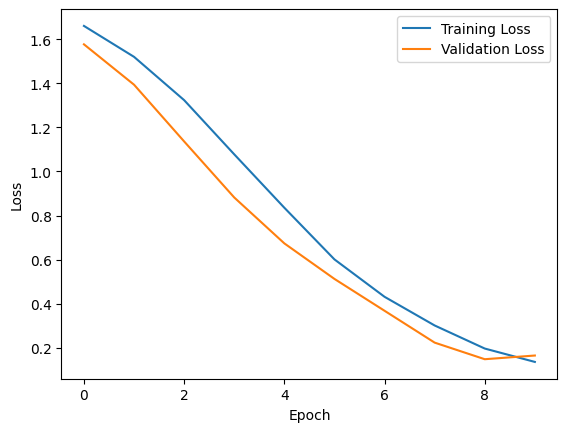

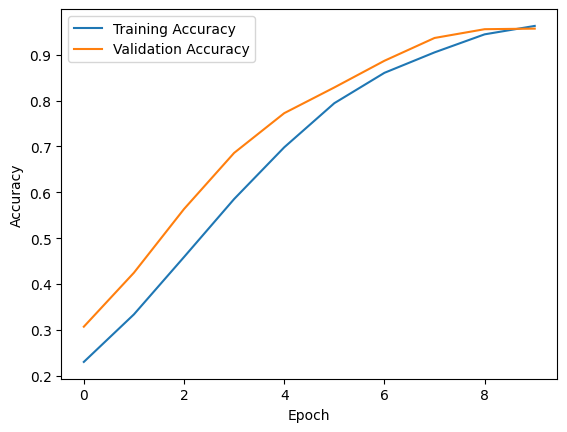

In [ ]:
# Mendapatkan data loss dari pelatihan
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Mendapatkan data akurasi dari pelatihan
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Menghasilkan plot untuk loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Menghasilkan plot untuk akurasi
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Save Model

In [ ]:
model.save('/content/drive/MyDrive/model fix/model.h5')

# Testing Model

In [62]:
from keras.models import load_model
from PIL import Image
import numpy as np

# Muat model
model = load_model('/content/drive/MyDrive/model fix/model.h5')

# Persiapkan data gambar
img = Image.open('/content/drive/MyDrive/faceshape/testing_set/Oblong/oblong (920).jpg')
img = img.resize((150, 150))  # Sesuaikan dengan dimensi input model Anda
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)

# Lakukan prediksi
predictions = model.predict(img_array)

# Interpretasikan hasil prediksi
label_names = ['Square', 'Oblong', 'Round', 'Oval', 'Heart']
predicted_label = label_names[np.argmax(predictions)]

print("Your face shape is:", predicted_label)

1/1 [==============================] - 0s 100ms/step
Your face shape is: Oblong


# Rekomendasi Hairstyle

1/1 [==============================] - 0s 62ms/step


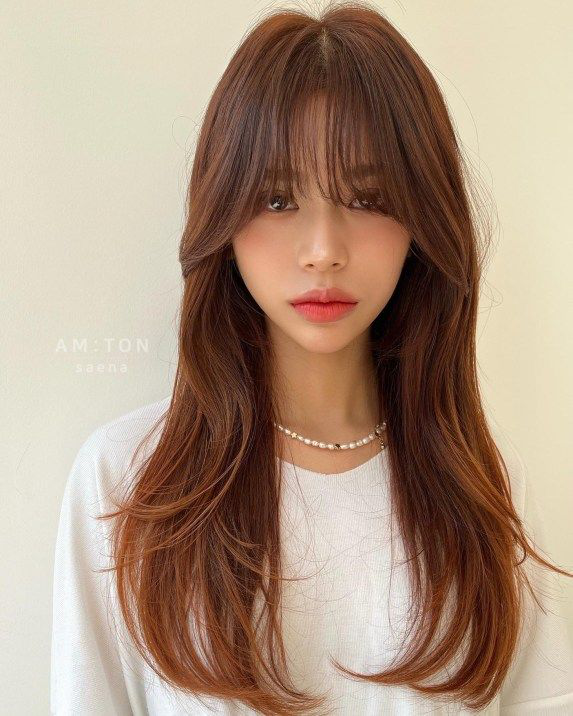

Rekomendasi potongan rambut: Poni Samping


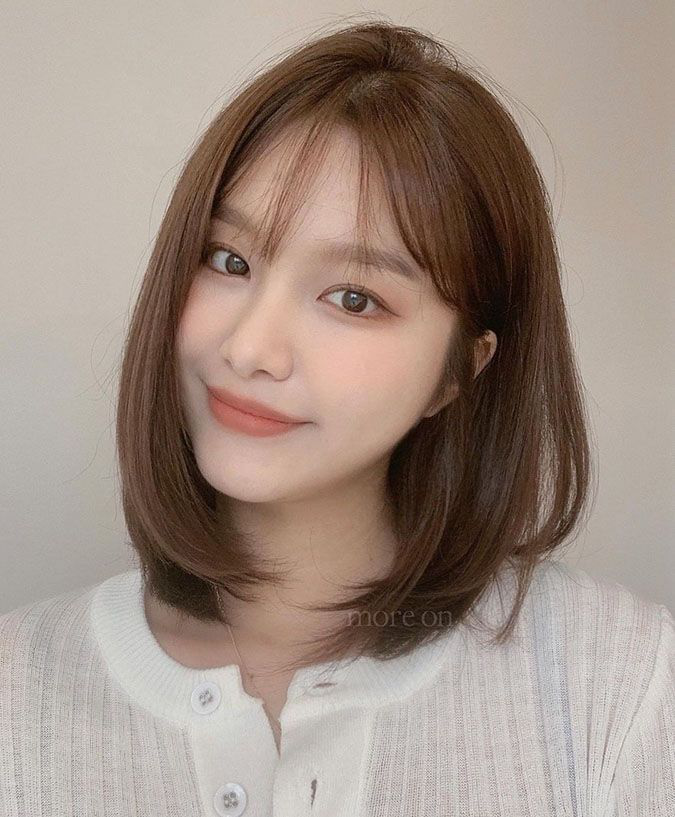

Rekomendasi potongan rambut: Bob


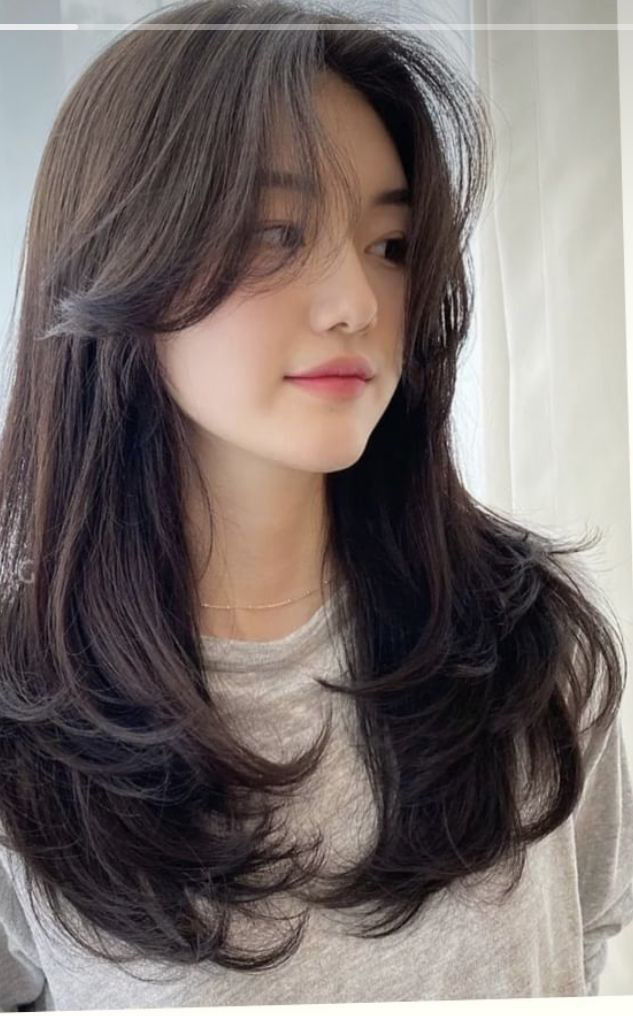

Rekomendasi potongan rambut: Layer


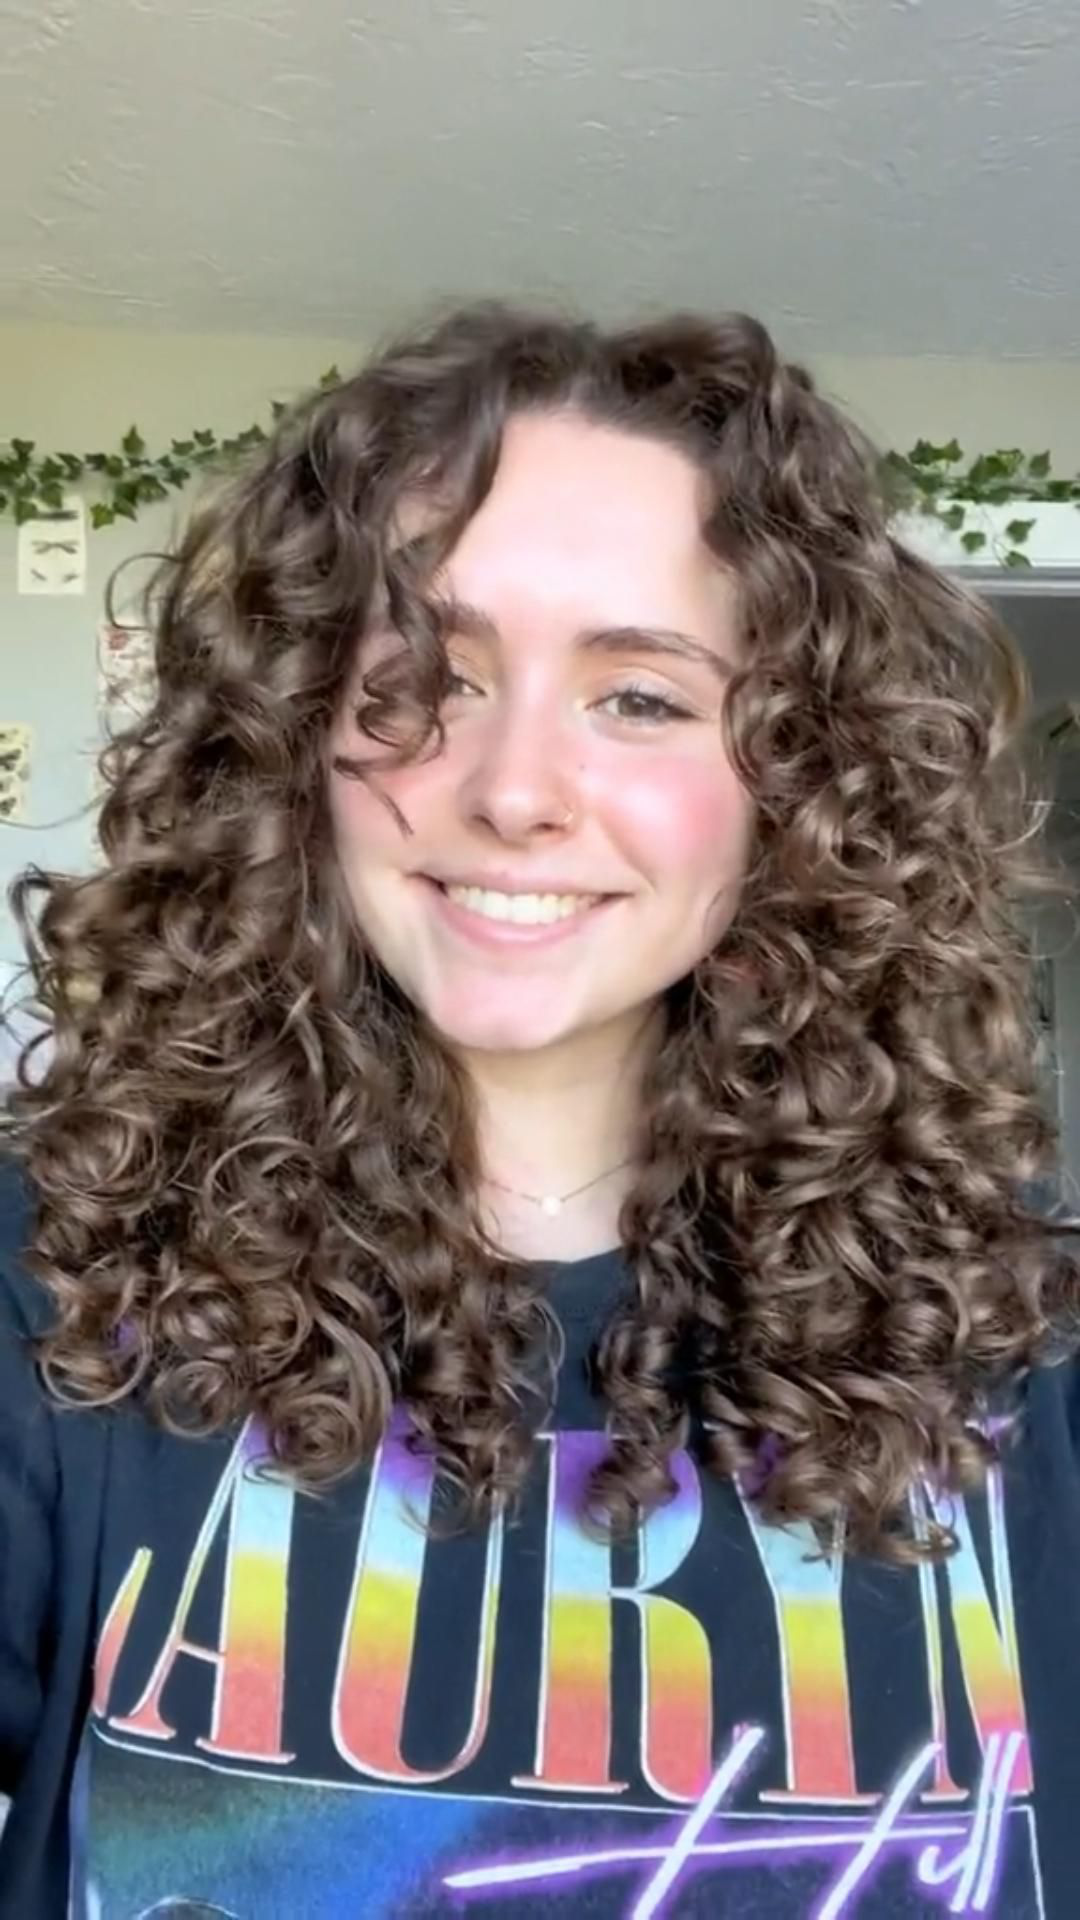

Rekomendasi potongan rambut: Bergelombang


In [63]:
import os
import random
from PIL import Image

# Hasil prediksi bentuk wajah
hasil_prediksi = model.predict(img_array)  # Ganti dengan hasil prediksi dari model

# Daftar label bentuk wajah
label_names = ['Square', 'Oblong', 'Round', 'Oval', 'Heart']

# Mengambil label bentuk wajah dari hasil prediksi
predicted_label_index = np.argmax(hasil_prediksi)
predicted_label = label_names[predicted_label_index]

# Path folder rekomendasi dataset potongan rambut
rekomendasi_folder = '/content/drive/MyDrive/recommendation'

# Path folder bentuk wajah yang sesuai dengan hasil prediksi
folder_bentuk_wajah = os.path.join(rekomendasi_folder, predicted_label)

# Mendapatkan daftar folder model potongan rambut yang sesuai dengan bentuk wajah
daftar_model_potongan_rambut = os.listdir(folder_bentuk_wajah)

# Memastikan jumlah folder model potongan rambut yang cukup
if len(daftar_model_potongan_rambut) >= 5:
    # Memilih secara acak 5 folder model potongan rambut
    model_potongan_rambut_terpilih = random.sample(daftar_model_potongan_rambut, k=5)
else:
    model_potongan_rambut_terpilih = daftar_model_potongan_rambut

# Menampilkan rekomendasi potongan rambut
for model_potongan_rambut in model_potongan_rambut_terpilih:
    path_model_potongan_rambut = os.path.join(folder_bentuk_wajah, model_potongan_rambut)
    daftar_gambar = os.listdir(path_model_potongan_rambut)
    gambar_terpilih = random.choice(daftar_gambar)
    label_potongan_rambut = model_potongan_rambut  # Ganti dengan label yang sesuai
    path_gambar_terpilih = os.path.join(path_model_potongan_rambut, gambar_terpilih)

    # Menampilkan gambar potongan rambut
    img = Image.open(path_gambar_terpilih)av 
    img.show()

    # Menampilkan label potongan rambut
    print("Rekomendasi potongan rambut:", label_potongan_rambut)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
